In [7]:
 # Parameters
dataset_path = "default_value.csv"

In [8]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # Added import for LabelEncoder
from collections import Counter

In [9]:
# Step 1: Load the CSV dataset
def load_data(csv_path):
    data = pd.read_csv(csv_path, low_memory=False)
    data = data.sample(frac=1, random_state=42)  # Shuffle data
    return data

# Step 2: Prepare the dataset for 1D CNN
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Step 2: Prepare the dataset for 1D CNN
def prepare_data(data):
    # Drop rows with missing values
    data = data.dropna()
    
    label_col = 'label'

    # Encode the 'protocol' column if it exists
    if 'protocol' in data.columns:
        le = LabelEncoder()
        data['protocol'] = le.fit_transform(data['protocol'])

    # Define feature columns (all columns except the label)
    feature_columns = data.columns.difference([label_col]).tolist()

    # Convert features to float32
    features = data[feature_columns].values.astype(np.float32)

    # Encode labels as integers and capture all unique classes
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data[label_col].values)
    classes = label_encoder.classes_
    
    return features, labels, classes


# Step 3: Create a custom PyTorch Dataset class
class DDoSDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx].unsqueeze(0), self.labels[idx]  # Add channel dimension

In [ ]:
# Step 4: Load data, split into train, validation, and test sets
data = load_data(dataset_path)
features, labels = prepare_data(data)

# First split: 70% for training, 30% for validation + test
train_feats, temp_feats, train_labels, temp_labels = train_test_split(
    features, labels, test_size=0.3, random_state=42
)

# Second split: Split 30% into 15% validation and 15% test
val_feats, test_feats, val_labels, test_labels = train_test_split(
    temp_feats, temp_labels, test_size=0.5, random_state=42
)

# Handle class imbalance using WeightedRandomSampler
class_counts = Counter(train_labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create DataLoaders
train_dataset = DDoSDataset(train_feats, train_labels)
val_dataset = DDoSDataset(val_feats, val_labels)
test_dataset = DDoSDataset(test_feats, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Step 5: Define the 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (input_size // 2 // 2), 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Step 6: Initialize model, loss, and optimizer
input_size = features.shape[1]
num_classes = len(set(labels))

model = CNN1D(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Step 7: Train the model with validation
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 5455.9035, Validation Loss: 1.8309, Validation Accuracy: 55.56%
Epoch 2/10, Loss: 1.3072, Validation Loss: 1.8309, Validation Accuracy: 55.56%
Epoch 3/10, Loss: 1.3072, Validation Loss: 1.8308, Validation Accuracy: 55.56%
Epoch 4/10, Loss: 1.3072, Validation Loss: 1.8309, Validation Accuracy: 55.56%
Epoch 5/10, Loss: 1.3072, Validation Loss: 1.8308, Validation Accuracy: 55.56%
Epoch 6/10, Loss: 1.3072, Validation Loss: 1.8308, Validation Accuracy: 55.56%
Epoch 7/10, Loss: 1.3072, Validation Loss: 1.8309, Validation Accuracy: 55.56%
Epoch 8/10, Loss: 1.3072, Validation Loss: 1.8308, Validation Accuracy: 55.56%
Epoch 9/10, Loss: 1.3072, Validation Loss: 1.8310, Validation Accuracy: 55.56%
Epoch 10/10, Loss: 1.3072, Validation Loss: 1.8308, Validation Accuracy: 55.56%


In [14]:
# Step 8: Evaluate on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []  # To store true labels
    y_pred = []  # To store predicted labels

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append the current batch's true and predicted labels to the lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    return y_true, y_pred

# Get the true and predicted labels
y_true, y_pred = evaluate_model(model, test_loader)

Test Accuracy: 55.54%


In [15]:
#V1:Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.56      1.00      0.71    361511
           1       0.00      0.00      0.00    102708
           2       0.00      0.00      0.00       278
           3       0.00      0.00      0.00     86728
           4       0.00      0.00      0.00      7598
           5       0.00      0.00      0.00     69082
           6       0.00      0.00      0.00     21062
           7       0.00      0.00      0.00      1980
           8       0.00      0.00      0.00         1

    accuracy                           0.56    650948
   macro avg       0.06      0.11      0.08    650948
weighted avg       0.31      0.56      0.40    650948



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


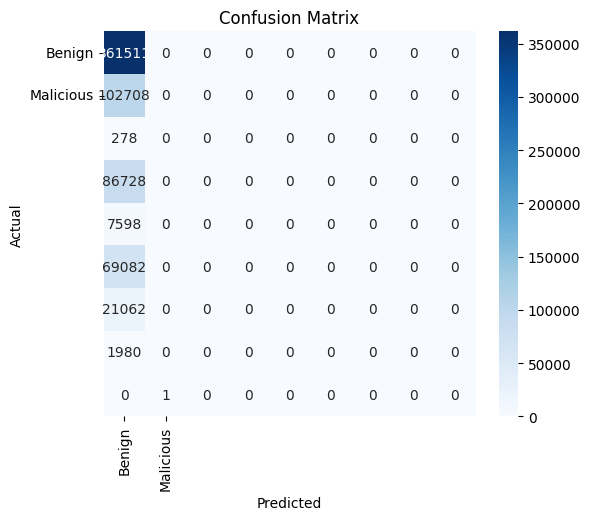

In [16]:
#V2:Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are your true labels and predictions respectively,
# and that you retrieved the classes from prepare_data.
# For example:
# features, labels, classes = prepare_data(data)
# ... train your model, then:
# y_pred = model.predict(X_test)
# and you have y_true from the test split.

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


IndexError: list index out of range

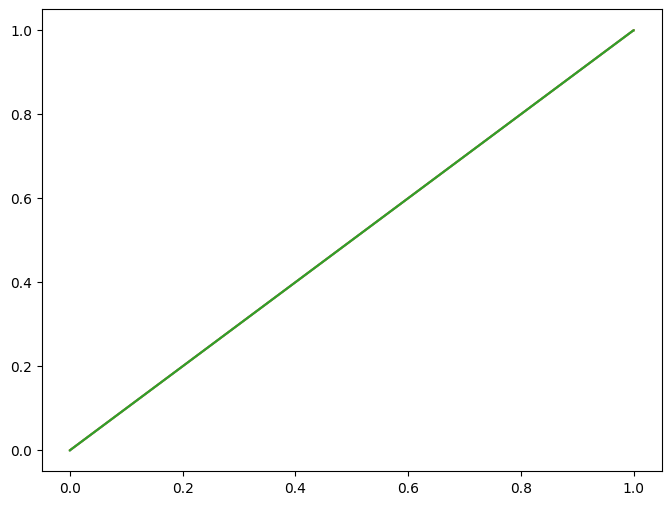

In [17]:
#V3: ROC Curve
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def get_predictions_and_probabilities(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Get model predictions (logits)
            prob = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            y_true.extend(labels.cpu().numpy())  # Append ground truth labels
            y_pred_prob.extend(prob.cpu().numpy())  # Append predicted probabilities

    y_pred_prob = np.array(y_pred_prob)
    return y_true, y_pred_prob

# Get true labels and predicted probabilities
y_true, y_pred_prob = get_predictions_and_probabilities(model, test_loader, device)

# Dynamically generate class names based on the number of classes
n_classes = y_pred_prob.shape[1]
class_names = [f"Class {i}" for i in range(n_classes)]

plt.figure(figsize=(8, 6))

# Loop over each class and calculate the ROC curve
for i in range(n_classes):
    # Calculate ROC curve for class i
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line representing random classifier
plt.title("ROC Curve for 1D CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.grid()
plt.show()